In [1]:
import glob
import os
from random import shuffle
from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
from tensorflow import keras
word_vector=KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin',binary=True)

def pre_process_data(filepath):
    positive_path=os.path.join(filepath,'pos')
    negative_path=os.path.join(filepath,'neg')
    pos_label=1
    neg_label=0
    dataset=[]
    for filename in glob.glob(os.path.join(positive_path,'*.txt')):
        dataset.append((pos_label,filename))
    for filename in glob.glob(os.path.join(negative_path,'*.txt')):
        dataset.append((neg_label,filename))
    shuffle(dataset)
    return dataset

dataset=pre_process_data('data/aclImdb/train')
split_point=int(len(dataset)*0.8)
trainData=dataset[:split_point]
testData=dataset[split_point:]
tokenizer=TreebankWordTokenizer()


trainlen=len(trainData)
testlen=len(testData)

def token_and_vectorize(filename,tokenizers):
    sample_vec=[]
    with open(filename,'r') as f:
        tokens=tokenizer.tokenize(f.read())
        for token in tokens:
            try:
                sample_vec.append(word_vector[token])
            except:
                pass
    return sample_vec

def pad_trunc(data,maxlen=400):
    zero_vector=[]
    for _ in range(len(data[0])):
        zero_vector.append(0.0)
    if len(data)>maxlen:
        temp=data[:maxlen]
    elif len(data)<maxlen:
        temp=data
        additional_elems=maxlen-len(data)
        for _ in range(additional_elems):
            temp.append(zero_vector)
    else:
        temp=data
    return temp

maxlen=400
batch_size=32
embedding_dims=300
epochs=10
dataset[:5]

[(1, 'data/aclImdb/train/pos/6309_8.txt'),
 (0, 'data/aclImdb/train/neg/5664_2.txt'),
 (1, 'data/aclImdb/train/pos/11888_9.txt'),
 (1, 'data/aclImdb/train/pos/4983_7.txt'),
 (1, 'data/aclImdb/train/pos/8621_10.txt')]

In [2]:
s=[]
with open(dataset[0][1],'r') as f:
    tokens=tokenizer.tokenize(f.read())
    for token in tokens:
        try:
            s.append(word_vector[token])
        except:
            pass
s=token_and_vectorize(dataset[0][1],tokenizer)
sd=pad_trunc(s,maxlen=400)
len(sd)

400

In [3]:
def data_generator_second(data_store,tokenizers,batchsize=32,maxlen=400,embedding_dims=300):
    X,Y=[],[]
    while True:
        for i in range(len(data_store)):
            if (i % batchsize==0 and X and Y) or (i==len(data_store)):
                X=np.reshape(X,(len(X),maxlen,embedding_dims))
                Y=np.array(Y)
                yield X,Y
                X,Y=[],[]
            x,y=data_store[i][1],data_store[i][0]
            x=pad_trunc(token_and_vectorize(x,tokenizers),maxlen=maxlen)    
            X.append(x)
            Y.append(y)


In [4]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,SimpleRNN
num_neurons=50
model=Sequential()
model.add(SimpleRNN(num_neurons,return_sequences=True,input_shape=(maxlen,embedding_dims)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

In [5]:
model.compile(optimizer='rmsprop',metrics=['accuracy'],loss='binary_crossentropy')

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 400, 50)           17550     
_________________________________________________________________
dropout (Dropout)            (None, 400, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 20001     
Total params: 37,551
Trainable params: 37,551
Non-trainable params: 0
_________________________________________________________________


In [7]:
import math
X_test=data_generator_second(testData,tokenizer,batchsize=batch_size,maxlen=maxlen)
history=model.fit_generator(data_generator_second(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=10,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))

Epoch 1/10
625/625 [==============================] - 73s 115ms/step - loss: 0.6518 - accuracy: 0.6476 - val_loss: 0.5236 - val_accuracy: 0.7532
Epoch 2/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4391 - accuracy: 0.8015 - val_loss: 0.5429 - val_accuracy: 0.7634
Epoch 3/10
625/625 [==============================] - 65s 104ms/step - loss: 0.3608 - accuracy: 0.8455 - val_loss: 0.5429 - val_accuracy: 0.7786
Epoch 4/10
625/625 [==============================] - 64s 103ms/step - loss: 0.3007 - accuracy: 0.8735 - val_loss: 0.5639 - val_accuracy: 0.7778
Epoch 5/10
625/625 [==============================] - 64s 103ms/step - loss: 0.2559 - accuracy: 0.8933 - val_loss: 0.5897 - val_accuracy: 0.7804
Epoch 6/10
625/625 [==============================] - 64s 103ms/step - loss: 0.2295 - accuracy: 0.9028 - val_loss: 0.6134 - val_accuracy: 0.7832
Epoch 7/10
625/625 [==============================] - 65s 105ms/step - loss: 0.1988 - accuracy: 0.9170 - val_loss: 0.6666 - val_ac

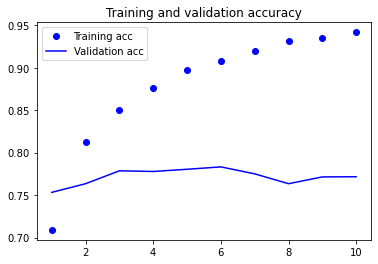

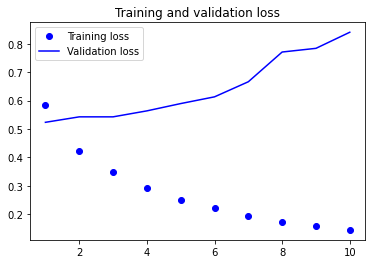

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("data/filename.png")
plt.show()

In [9]:
m_s=model.to_json()
with open('simplernn_model.json','w') as json_file:
    json_file.write(m_s)
model.save_weights('simplernn_weights.h5')

Epoch 1/10
625/625 [==============================] - 66s 105ms/step - loss: 0.8307 - accuracy: 0.6116 - val_loss: 0.5994 - val_accuracy: 0.7260
Epoch 2/10
625/625 [==============================] - 65s 104ms/step - loss: 0.4725 - accuracy: 0.7870 - val_loss: 0.5876 - val_accuracy: 0.7514
Epoch 3/10
625/625 [==============================] - 64s 103ms/step - loss: 0.3473 - accuracy: 0.8521 - val_loss: 0.6432 - val_accuracy: 0.7516
Epoch 4/10
625/625 [==============================] - 65s 104ms/step - loss: 0.2720 - accuracy: 0.8846 - val_loss: 0.6616 - val_accuracy: 0.7582
Epoch 5/10
625/625 [==============================] - 65s 103ms/step - loss: 0.2203 - accuracy: 0.9073 - val_loss: 0.7689 - val_accuracy: 0.7548
Epoch 6/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1821 - accuracy: 0.9255 - val_loss: 0.7796 - val_accuracy: 0.7614
Epoch 7/10
625/625 [==============================] - 64s 103ms/step - loss: 0.1553 - accuracy: 0.9351 - val_loss: 0.8456 - val_ac

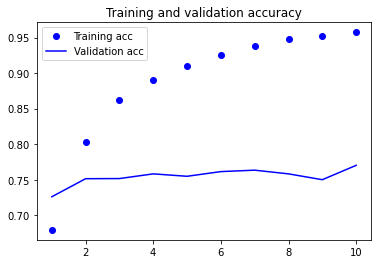

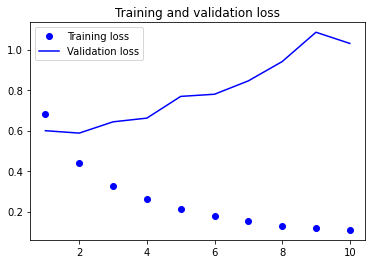

In [12]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,SimpleRNN
num_neurons=100

model1=Sequential()
model1.add(SimpleRNN(num_neurons,return_sequences=True,input_shape=(maxlen,embedding_dims)))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(1,activation='sigmoid'))
model1.compile(optimizer='rmsprop',metrics=['accuracy'],loss='binary_crossentropy')
model1.summary
history=model1.fit_generator(data_generator_second(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=10,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))
import matplotlib.pyplot as plt

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("data/filename.png")
plt.show()

In [20]:
m_s=model1.to_json()
with open('simplernn_model1.json','w') as json_file:
    json_file.write(m_s)
model1.save_weights('simplernn_weights1.h5')

Epoch 1/10
625/625 [==============================] - 65s 104ms/step - loss: 0.6164 - accuracy: 0.6529 - val_loss: 0.5644 - val_accuracy: 0.7260
Epoch 2/10
625/625 [==============================] - 66s 105ms/step - loss: 0.4354 - accuracy: 0.8062 - val_loss: 0.5353 - val_accuracy: 0.7568
Epoch 3/10
625/625 [==============================] - 65s 105ms/step - loss: 0.3826 - accuracy: 0.8350 - val_loss: 0.4979 - val_accuracy: 0.7856
Epoch 4/10
625/625 [==============================] - 65s 105ms/step - loss: 0.3464 - accuracy: 0.8537 - val_loss: 0.5208 - val_accuracy: 0.7844
Epoch 5/10
625/625 [==============================] - 66s 105ms/step - loss: 0.3132 - accuracy: 0.8698 - val_loss: 0.5242 - val_accuracy: 0.7852
Epoch 6/10
625/625 [==============================] - 65s 104ms/step - loss: 0.2887 - accuracy: 0.8815 - val_loss: 0.5373 - val_accuracy: 0.7888
Epoch 7/10
625/625 [==============================] - 64s 103ms/step - loss: 0.2673 - accuracy: 0.8887 - val_loss: 0.5272 - val_ac

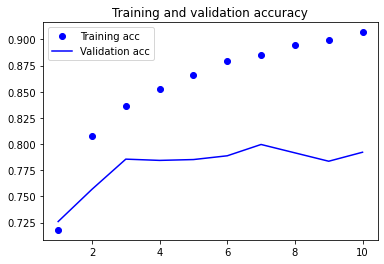

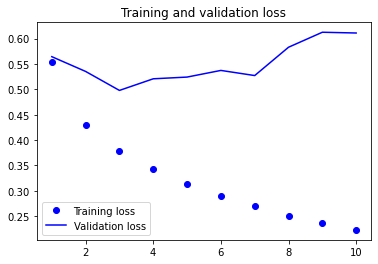

In [13]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,SimpleRNN
num_neurons=25

model2=Sequential()
model2.add(SimpleRNN(num_neurons,return_sequences=True,input_shape=(maxlen,embedding_dims)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(1,activation='sigmoid'))
model2.compile(optimizer='rmsprop',metrics=['accuracy'],loss='binary_crossentropy')
model2.summary
history2=model2.fit_generator(data_generator_second(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=10,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))
import matplotlib.pyplot as plt

acc = history2.history['accuracy']

val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("data/filename2.png")
plt.show()
m_s=model2.to_json()
with open('simplernn_model2.json','w') as json_file:
    json_file.write(m_s)
model2.save_weights('simplernn_weights2.h5')

In [14]:
def token_and_vectorize_str(strString,tokenizers):
    sample_vec=[]
    tokens=tokenizer.tokenize(strString)
    for token in tokens:
        try:
            sample_vec.append(word_vector[token])
        except:
            pass
    return sample_vec
sample_1="I hate that the dismal weather had me down for so long,when will it break! Ugh, when does happiness return? The sun is blinding and the puffy clouds are too thin. I can't wait for the weekend."
test_vec=pad_trunc(token_and_vectorize_str(sample_1,tokenizer),maxlen=maxlen)
test_vec=np.reshape(test_vec,(1,400,300))

In [33]:
from tensorflow.keras.models import model_from_json
with open('simplernn_model.json','r') as json_file:
    j_s=json_file.read()
modelX=model_from_json(j_s)
modelX.summary()
modelX.load_weights('simplernn_weights.h5')
modelX.predict(test_vec)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 400, 50)           17550     
_________________________________________________________________
dropout (Dropout)            (None, 400, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 20001     
Total params: 37,551
Trainable params: 37,551
Non-trainable params: 0
_________________________________________________________________


array([[0.16411717]], dtype=float32)

In [16]:
modelX.predict_classes(test_vec)

array([[0]], dtype=int32)

In [21]:
with open('simplernn_model1.json','r') as json_file:
    j_s=json_file.read()
modelX=model_from_json(j_s)
modelX.summary()
modelX.load_weights('simplernn_weights1.h5')
modelX.predict(test_vec)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 400, 100)          40100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 400, 100)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 40001     
Total params: 80,101
Trainable params: 80,101
Non-trainable params: 0
_________________________________________________________________


array([[0.03728375]], dtype=float32)

In [22]:
modelX.predict_classes(test_vec)

array([[0]], dtype=int32)

In [18]:
with open('simplernn_model2.json','r') as json_file:
    j_s=json_file.read()
modelX=model_from_json(j_s)
modelX.summary()
modelX.load_weights('simplernn_weights2.h5')
modelX.predict(test_vec)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 400, 25)           8150      
_________________________________________________________________
dropout_4 (Dropout)          (None, 400, 25)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 10001     
Total params: 18,151
Trainable params: 18,151
Non-trainable params: 0
_________________________________________________________________


array([[0.22820795]], dtype=float32)

In [19]:
modelX.predict_classes(test_vec)

array([[0]], dtype=int32)

Epoch 1/10
625/625 [==============================] - 97s 154ms/step - loss: 0.7405 - accuracy: 0.6296 - val_loss: 0.5856 - val_accuracy: 0.7410
Epoch 2/10
625/625 [==============================] - 95s 152ms/step - loss: 0.4451 - accuracy: 0.8000 - val_loss: 0.6224 - val_accuracy: 0.7522
Epoch 3/10
625/625 [==============================] - 92s 148ms/step - loss: 0.3256 - accuracy: 0.8588 - val_loss: 0.6781 - val_accuracy: 0.7520
Epoch 4/10
625/625 [==============================] - 92s 147ms/step - loss: 0.2474 - accuracy: 0.8934 - val_loss: 0.7008 - val_accuracy: 0.7584
Epoch 5/10
625/625 [==============================] - 95s 153ms/step - loss: 0.2005 - accuracy: 0.9170 - val_loss: 0.7317 - val_accuracy: 0.7716
Epoch 6/10
625/625 [==============================] - 94s 151ms/step - loss: 0.1681 - accuracy: 0.9313 - val_loss: 0.8552 - val_accuracy: 0.7594
Epoch 7/10
625/625 [==============================] - 96s 153ms/step - loss: 0.1377 - accuracy: 0.9451 - val_loss: 0.9135 - val_ac

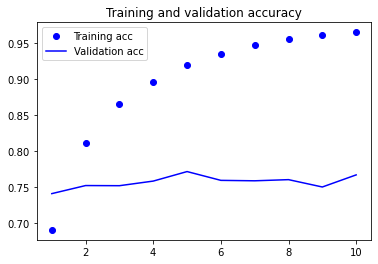

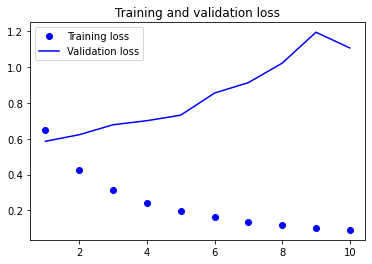

In [27]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,SimpleRNN
from tensorflow.keras.layers import Bidirectional
num_neurons=50

modelB=Sequential()
modelB.add(Bidirectional(SimpleRNN(num_neurons,return_sequences=True,input_shape=(maxlen,embedding_dims))))
modelB.add(Dropout(0.2))
modelB.add(Flatten())
modelB.add(Dense(1,activation='sigmoid'))
modelB.compile(optimizer='rmsprop',metrics=['accuracy'],loss='binary_crossentropy')
modelB.summary
historyB=modelB.fit_generator(data_generator_second(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=10,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))
import matplotlib.pyplot as plt

acc = historyB.history['accuracy']

val_acc = historyB.history['val_accuracy']
loss = historyB.history['loss']
val_loss = historyB.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("data/filename2.png")
plt.show()
m_s=modelB.to_json()
with open('simplernn_modelb.json','w') as json_file:
    json_file.write(m_s)
modelB.save_weights('simplernn_weightsb.h5')

In [34]:
m_s=modelB.to_json()
with open('simplernn_modelb.json','w') as json_file:
    json_file.write(m_s)
modelB.save_weights('simplernn_weightsb.h5')

In [36]:
# from tensorflow.keras.models import model_from_json
# with open('simplernn_modelb.json','r') as json_file:
#     j_s=json_file.read()
# print(j_s)
# modelXB=model_from_json(j_s)
# modelXB.summary()
# modelXB.load_weights('simplernn_weightsb.h5')
modelB.predict(test_vec)

array([[0.02099032]], dtype=float32)

In [37]:
modelB.predict_classes(test_vec)

array([[0]], dtype=int32)